<a href="https://colab.research.google.com/github/AntonioFuziy/APS2-DesafiosDeProgramacao/blob/master/AF_AntonioFuziy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUPERCOMPUTAÇÃO - AVALIAÇÃO FINAL - 13/06/2022**

**NOME: Antonio Fuziy**





In [9]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import subprocess
plt.style.use("ggplot")

def roda_com_entrada(executavel, n, num_threads):
  start = time.perf_counter()
  proc = subprocess.run([executavel, str(n), str(num_threads)], text=True, capture_output=True)
  end = time.perf_counter()
  return end-start

##Q1

**QUESTÃO 1.** Resolva a questão 1 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

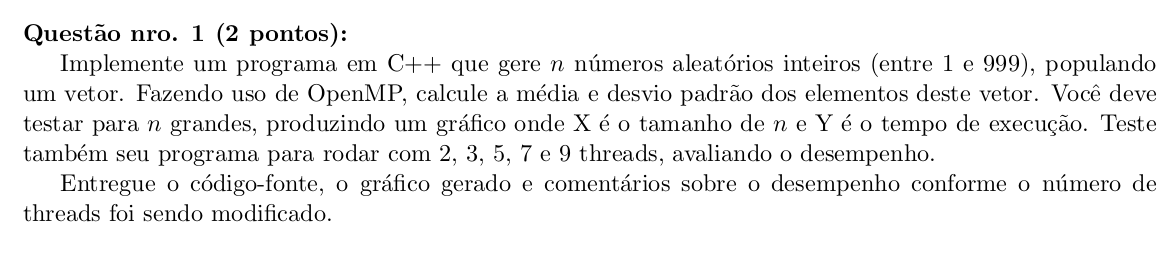

In [89]:
%%writefile q1.cpp

#include<iostream>
#include<vector>
#include<algorithm>
#include <random>
#include<cmath>
#include<omp.h>
#include<iomanip>

using namespace std;

int main(int argc, char** argv){
    int n;
    n = atoi(argv[1]);
    vector<int> random_vec;

    double init_time, final_time;
    default_random_engine generator(10);
    uniform_int_distribution<int> distribution(1, 999);

    float mean = 0;
    float std_dev = 0;
    int sum_mean = 0;
    int std_sum = 0;

    int num_threads = atoi(argv[2]);

    init_time = omp_get_wtime();
    omp_set_num_threads(num_threads);

    for(int i = 0; i < n; i++){
        random_vec.push_back(distribution(generator));
    }
    
    #pragma omp parallel for reduction(+:sum_mean)
    for(int i = 0; i < n; i++){
        sum_mean += random_vec[i];
    }

    mean = sum_mean / n;
    cout << "media: " << mean << endl;

    #pragma omp parallel for reduction(+:std_sum)
    for(int i = 0; i < n; i++){
        std_sum += pow(random_vec[i] - mean, 2);
    }

    std_dev = sqrt(std_sum / (n-1));
    cout << "desvio padrao: " << std_dev << endl;

    final_time = omp_get_wtime() - init_time;
    cout << "final time: " << final_time << endl;

    for(int i = 0; i < n; i++){
        cout << random_vec[i] << " ";
    }

    cout << endl;

    return 0;
}

Overwriting q1.cpp


In [90]:
!g++ -g -Wall -fopenmp q1.cpp -o q1

In [92]:
times_2 = []
times_3 = []
times_5 = []
times_7 = []
times_9 = []
length = []
threads = [2, 3, 5, 7, 9]
for n in range(1, 200):
  length.append(n)
  times_2.append(roda_com_entrada("/content/q1", n, 2))
  times_3.append(roda_com_entrada("/content/q1", n, 3))
  times_5.append(roda_com_entrada("/content/q1", n, 5))
  times_7.append(roda_com_entrada("/content/q1", n, 7))
  times_9.append(roda_com_entrada("/content/q1", n, 9))

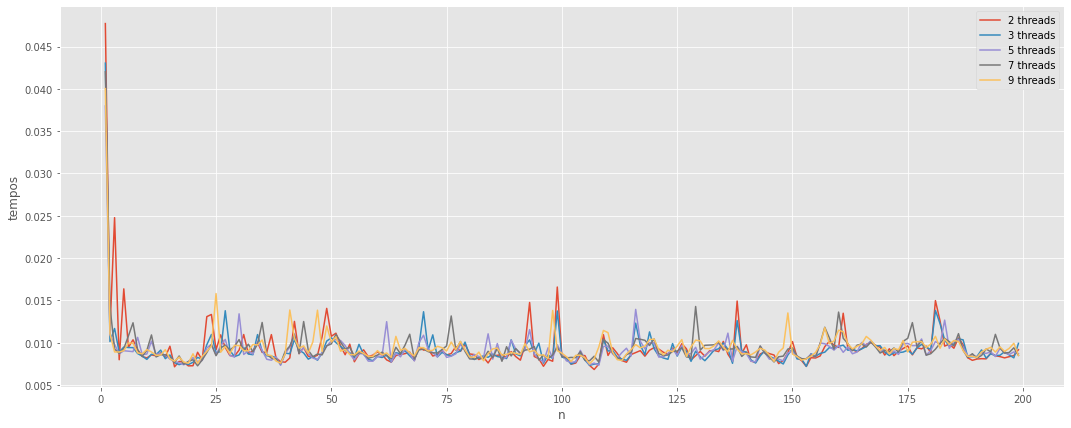

In [94]:
plt.figure(figsize=(18,7))
plt.plot(length, times_2, label="2 threads")
plt.plot(length, times_3, label="3 threads")
plt.plot(length, times_5, label="5 threads")
plt.plot(length, times_7, label="7 threads")
plt.plot(length, times_9, label="9 threads")
plt.xlabel("n")
plt.ylabel("tempos")
plt.legend()
plt.show()

**FEEDBACK QUESTÃO 1**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

##Q2

**QUESTÃO 2.** Resolva a questão 2 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

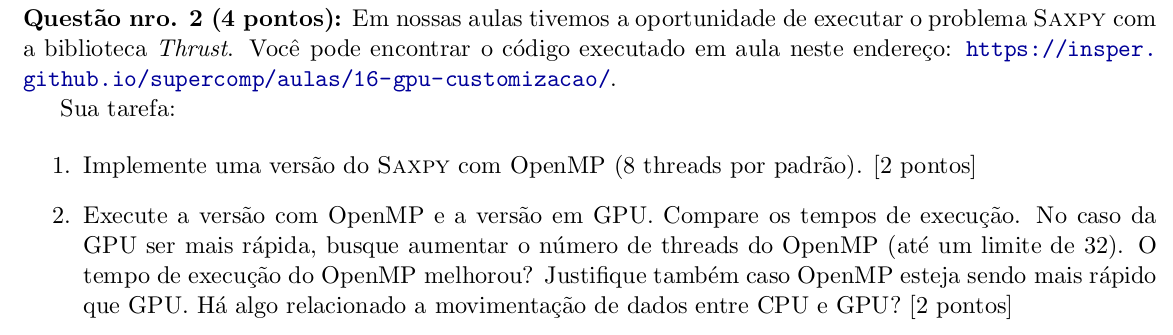

In [12]:
%%writefile q2.cpp
#include <cstdlib>
#include <algorithm>
#include <iostream>
#include<vector>
#include<algorithm>
#include <random>
#include <iomanip>
#include <omp.h>
#include<iomanip>
#include<cmath>

using namespace std;

int main(int argc, char** argv){
  int n, m;
  n = atoi(argv[1]);
  m = atoi(argv[2]);

  double init_time, final_time;

  init_time = omp_get_wtime();
  omp_set_num_threads(atoi(argv[3]));

  default_random_engine generator(10);
  uniform_int_distribution<int> distribution(1, n);

  vector<int> a;
  vector<int> b;
  vector<int> c;

  for(int i = 0; i < n; i++){
    a.push_back(distribution(generator));
    b.push_back(distribution(generator));
  }

  #pragma omp parallel for
  for(int i = 0; i < n; i++){
    c.push_back(m * a[i] + b[i]);
  }

  final_time = omp_get_wtime() - init_time;
  cout << "final time: " << final_time << endl;

  for(int i = 0; i < n; i++){
    cout << c[i] << " ";
  }

  cout << endl;

  return 0;    
}

Overwriting q2.cpp


In [13]:
!g++ -g -Wall -fopenmp q2.cpp -o q2

In [14]:
%%writefile q2_gpu.cu
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/generate.h>
#include <thrust/functional.h>
#include <thrust/copy.h>
#include <cstdlib>
#include <algorithm>
#include <iostream>
#include <iomanip>

using namespace  std;

struct saxpy
{
    int a;    
    saxpy(int a_) : a(a_) {};
    __host__ __device__
    double operator()(const int& x, const int& y) {
           return a * x + y;
    }
};

int main(int argc, char* argv[]) {
     if (argc != 3) {
         cerr <<
          "***Numero incorreto de argumentos ***\n";
         return 1;
     }

     int n = atoi(argv[1]);
     int m = atoi(argv[2]);

     //gerar numeros aleatorios
     thrust::host_vector<int> a(n);
     thrust::host_vector<int> b(n);
     thrust::host_vector<int> c(n);
     thrust::generate(a.begin(), a.end(), rand);
     thrust::generate(b.begin(), b.end(), rand);

     //transferimos para a GPU
     thrust::device_vector<int> d_a = a;
     thrust::device_vector<int> d_b = b;

     //transformacao

     thrust::transform(d_a.begin(), d_a.end(),
                       d_b.begin(), d_b.end(),
                       saxpy(m));

     thrust::copy(d_b.begin(), d_b.end(),
     c.begin()); 

     for (int i = 0; i < n; i++ )
         cout << setw(6) << c[i] << " = " 
          << setw(2) << m
          << "*" << setw(5) << a[i]
          << "+" << setw(5) << b[i]
          << endl;

}

Overwriting q2_gpu.cu


In [15]:
!nvcc -arch=sm_37 -std=c++14 q2_gpu.cu -o q2_gpu

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [18]:
def openmp_roda_com_entrada(executavel, n, m, num_threads):
  start = time.perf_counter()
  proc = subprocess.run([executavel, str(n), str(num_threads)], text=True, capture_output=True)
  end = time.perf_counter()
  return end-start

In [21]:
times_cpu_8 = []
times_cpu_32 = []
times_gpu = []
length = []
for n in range(1, 200):
  length.append(n)
  times_cpu_8.append(openmp_roda_com_entrada("/content/q2", n, 20, 8))
  times_cpu_32.append(openmp_roda_com_entrada("/content/q2", n, 20, 32))
  times_gpu.append(roda_com_entrada("/content/q2_gpu", n, 20))

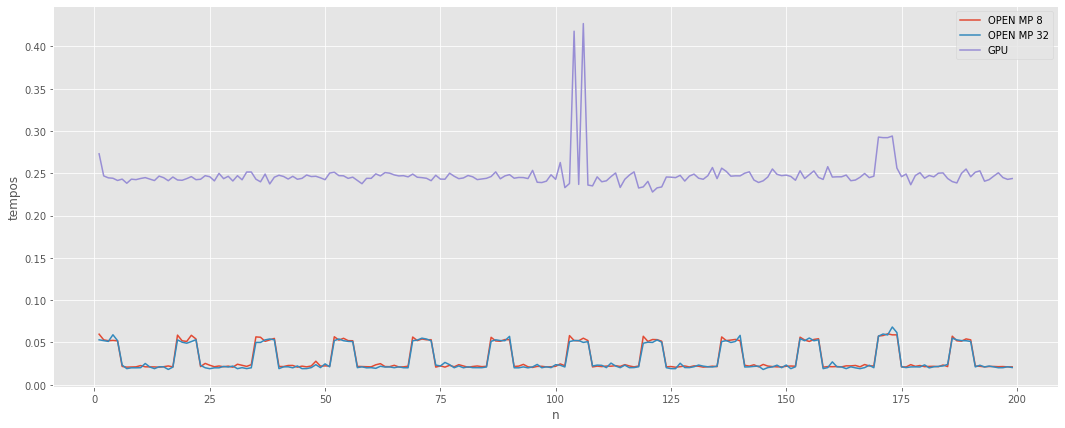

In [22]:
plt.figure(figsize=(18,7))
plt.plot(length, times_cpu_8, label="OPEN MP 8")
plt.plot(length, times_cpu_32, label="OPEN MP 32")
plt.plot(length, times_gpu, label="GPU")
plt.xlabel("n")
plt.ylabel("tempos")
plt.legend()
plt.show()

**FEEDBACK QUESTÃO 2**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

##Q3

**QUESTÃO 3.** Resolva a questão 3 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

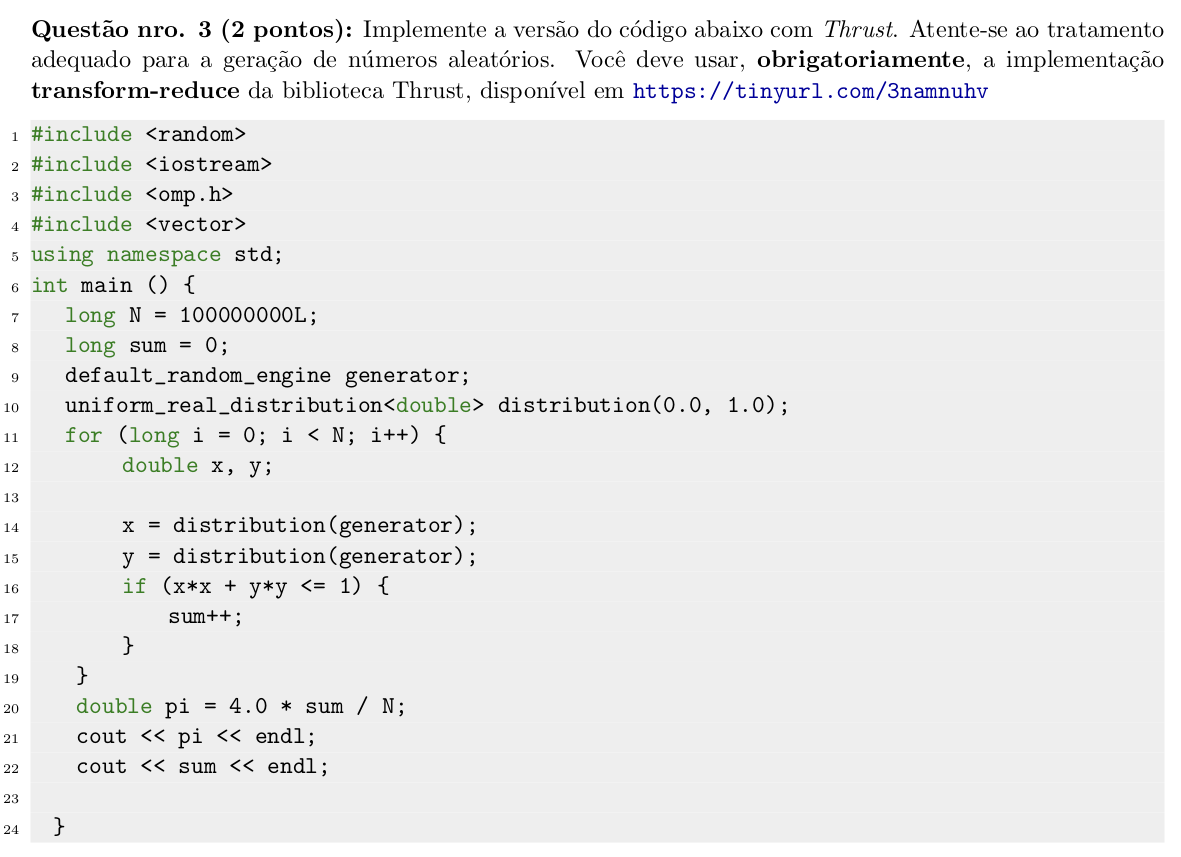

In [137]:
%%writefile q3.cu
#include <random>
#include <iostream>
#include <vector>
#include <iomanip>
#include <cstdlib>
#include <chrono>
#include <cstdlib>
#include <algorithm>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/generate.h>
#include <thrust/functional.h>
#include <thrust/transform_reduce.h>
#include <thrust/random.h>

struct random_generator {  
  __host__ __device__
  float operator() (const int n) {
    thrust::default_random_engine eng(n);
    thrust::uniform_real_distribution<float> d(0.0, 1.0);
    return d(eng);
  }
};

struct sum_of_square
{
  __host__ __device__
  float operator()(const float &x, const float &y){
    return pow(x,2) + pow(y,2);
  }
};

struct unary_operation
{
  __host__ __device__
  float operator()(const float &sum){
    if(sum <= 1){
      return 1;
    }
    return 0;
  } 
};

int main () {
  long N = 100000000L;
  long sum = 0;

  thrust::device_vector<float> a_gpu(N);
  thrust::device_vector<float> b_gpu(N);

  thrust::transform(
    thrust::make_counting_iterator<long>(0),
    thrust::make_counting_iterator<long>(N),
    a_gpu.begin(),
    random_generator()
  );

  thrust::transform(
    thrust::make_counting_iterator<long>(N),
    thrust::make_counting_iterator<long>(2*N),
    b_gpu.begin(),
    random_generator()
  );

  thrust::transform(
    a_gpu.begin(), a_gpu.end(), 
    b_gpu.begin(), b_gpu.begin(), 
    sum_of_square()
  );

  sum = thrust::transform_reduce(
    b_gpu.begin(), b_gpu.end(), 
    unary_operation(), 
    (long) 0.0, 
    thrust::plus<float>()
  );

  float result = 4 * sum / (float) N; 
  
  std::cout << result << std::endl;
}

Overwriting q3.cu


In [138]:
!nvcc -arch=sm_37 -std=c++14 q3.cu -o q3

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [139]:
!./q3

3.13952


##Q4

**FEEDBACK QUESTÃO 3**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 4.** Resolva a questão 4 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

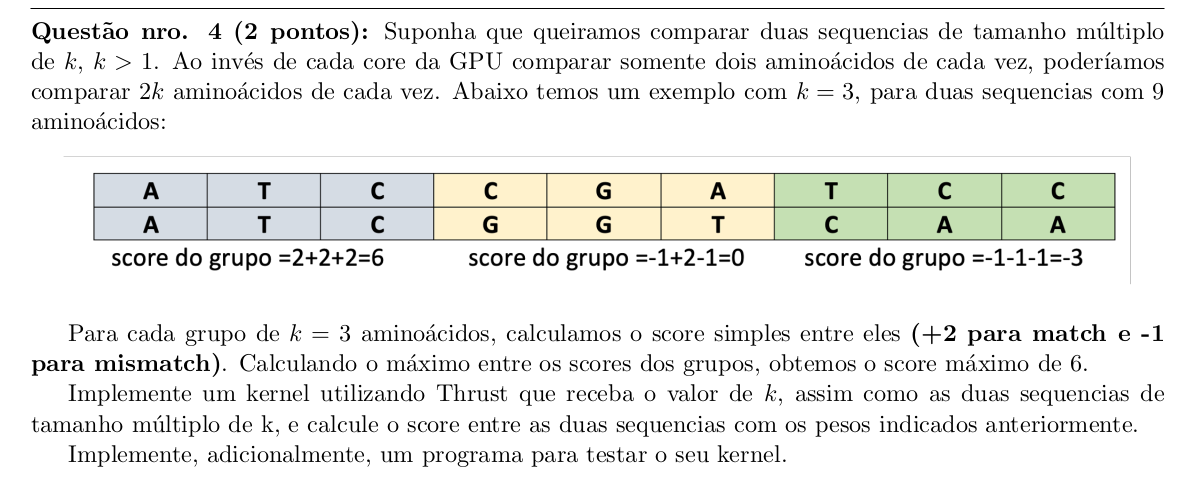

In [ ]:
#espaço para codificação

**FEEDBACK QUESTÃO 4:** Não preencher este campo. Ele será preenchido pelo seu professor durante a correção.